Compare the performance of different Classification and Regression datasets by using the Default Dataset.

In [1]:
# %load ../standard_import.txt
#import all important packages

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')

/Users/arsheenkhatib/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


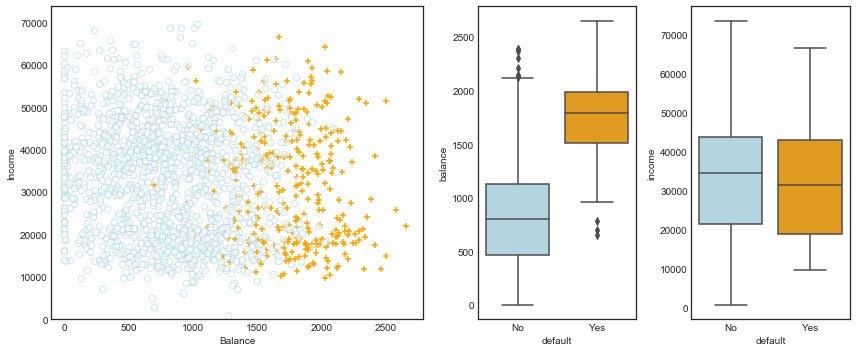

In [2]:
#READ THE DEFAULT.CSV FILE AND CREATE A SCATTER PLOT AND A BOXPLOT FOR INCOME VS BALANCE

df = pd.read_csv('Desktop/Default.csv')
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]

fig = plt.figure(figsize=(12,5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

# Take a fraction of the samples where target value (default) is 'no'
df_no = df[df.default2 == 0].sample(frac=0.15)
# Take all samples  where target value is 'yes'
df_yes = df[df.default2 == 1]
df_ = df_no.append(df_yes)

ax1.scatter(df_[df_.default == 'Yes'].balance, df_[df_.default == 'Yes'].income, s=40, c='orange', marker='+',
            linewidths=1)
ax1.scatter(df_[df_.default == 'No'].balance, df_[df_.default == 'No'].income, s=40, marker='o', linewidths='1',
            edgecolors='lightblue', facecolors='white', alpha=.6)

ax1.set_ylim(ymin=0)
ax1.set_ylabel('Income')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Balance')

c_palette = {'No':'lightblue', 'Yes':'orange'}
sns.boxplot('default', 'balance', data=df, orient='v', ax=ax2, palette=c_palette)
sns.boxplot('default', 'income', data=df, orient='v', ax=ax3, palette=c_palette)
gs.tight_layout(plt.gcf())



In [3]:
#USE SCIKIT-LEARN LINEAR MODEL TO CLASS, COEFFICIENTS AND INTERCEPTS USING LOGICAL REGRESSION

y = df.default2

#scikit-learn
clf = skl_lm.LogisticRegression(solver='newton-cg')
X_train = df.balance.values.reshape(-1,1)
clf.fit(X_train,y)
print(clf)
print('classes: ',clf.classes_)
print('coefficients: ',clf.coef_)
print('intercept :', clf.intercept_)

#statsmodels
X_train = sm.add_constant(df.balance)
est = smf.Logit(y.ravel(), X_train).fit()
est.summary2().tables[1]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)
classes:  [0 1]
coefficients:  [[ 0.00549892]]
intercept : [-10.65132998]
Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


/Users/arsheenkhatib/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/arsheenkhatib/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-10.651331,0.361169,-29.491287,3.723665e-191,-11.359208,-9.943453
balance,0.005499,0.000220,24.952404,2.010855e-137,0.005067,0.005931


In [4]:
#FIND THE STD. ERROR
X_train = sm.add_constant(df.student2)
y = df.default2

est = smf.Logit(y, X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-3.504128,0.070713,-49.554094,0.000000,-3.642723,-3.365532
student2,0.404887,0.115019,3.520177,0.000431,0.179454,0.630320


In [5]:
#Multiple Logistic Regression

X_train = sm.add_constant(df[['balance', 'income', 'student2']])
est = smf.Logit(y, X_train).fit()
est.summary2().tables[1]


Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-10.869045,0.492273,-22.079320,4.995499e-108,-11.833882,-9.904209
balance,0.005737,0.000232,24.736506,4.331521e-135,0.005282,0.006191
income,0.000003,0.000008,0.369808,7.115254e-01,-0.000013,0.000019
student2,-0.646776,0.236257,-2.737595,6.189022e-03,-1.109831,-0.183721


In [6]:
# FIND THE TRUE POSITIVES, TRUE NEGATIVES, FALSE POSITIVES, AND FALSE NEGATIVES
X = df[['balance', 'income', 'student2']].as_matrix()
y = df.default2.as_matrix()

lda = LinearDiscriminantAnalysis(solver='svd')
y_pred = lda.fit(X, y).predict(X)

df_ = pd.DataFrame({'True default status': y,
                    'Predicted default status': y_pred})
df_.replace(to_replace={0:'No', 1:'Yes'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status,No,Yes
Predicted default status,,
No,9645,254
Yes,22,79


In [7]:
#PRINT THE CLASSIFICATION REPORT
print(classification_report(y, y_pred, target_names=['No', 'Yes']))

             precision    recall  f1-score   support

         No       0.97      1.00      0.99      9667
        Yes       0.78      0.24      0.36       333

avg / total       0.97      0.97      0.97     10000



------------------------------------------------------------------------------------------------

In [8]:
#READ THE DEFAULT AUTO_CLEANED DATASET
import pandas as pd
auto = pd.read_csv('Desktop/Auto_cleaned.csv')

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


A) Create a binary variable, mpg01, that contains 1 if mpg contains a value above its median, and a 0 if mpg contains a value below its median.

In [10]:
auto['mpg01'] = np.where(auto['mpg'] > auto['mpg'].median(), 1, 0)
#del auto['Unnamed: 0']
auto.corr()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,mpg01
mpg,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.565209,0.836939
cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932,-0.759194
displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535,-0.753477
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171,-0.667053
weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005,-0.757757
acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746,0.346822
year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528,0.429904
origin,0.565209,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000,0.513698
mpg01,0.836939,-0.759194,-0.753477,-0.667053,-0.757757,0.346822,0.429904,0.513698,1.000000


B) Explore the data graphically in order to investigate the association between
mpg01 and the other features. Which of the other features seem most likely to be
useful in predicting mp01? (Scatter and box plots)

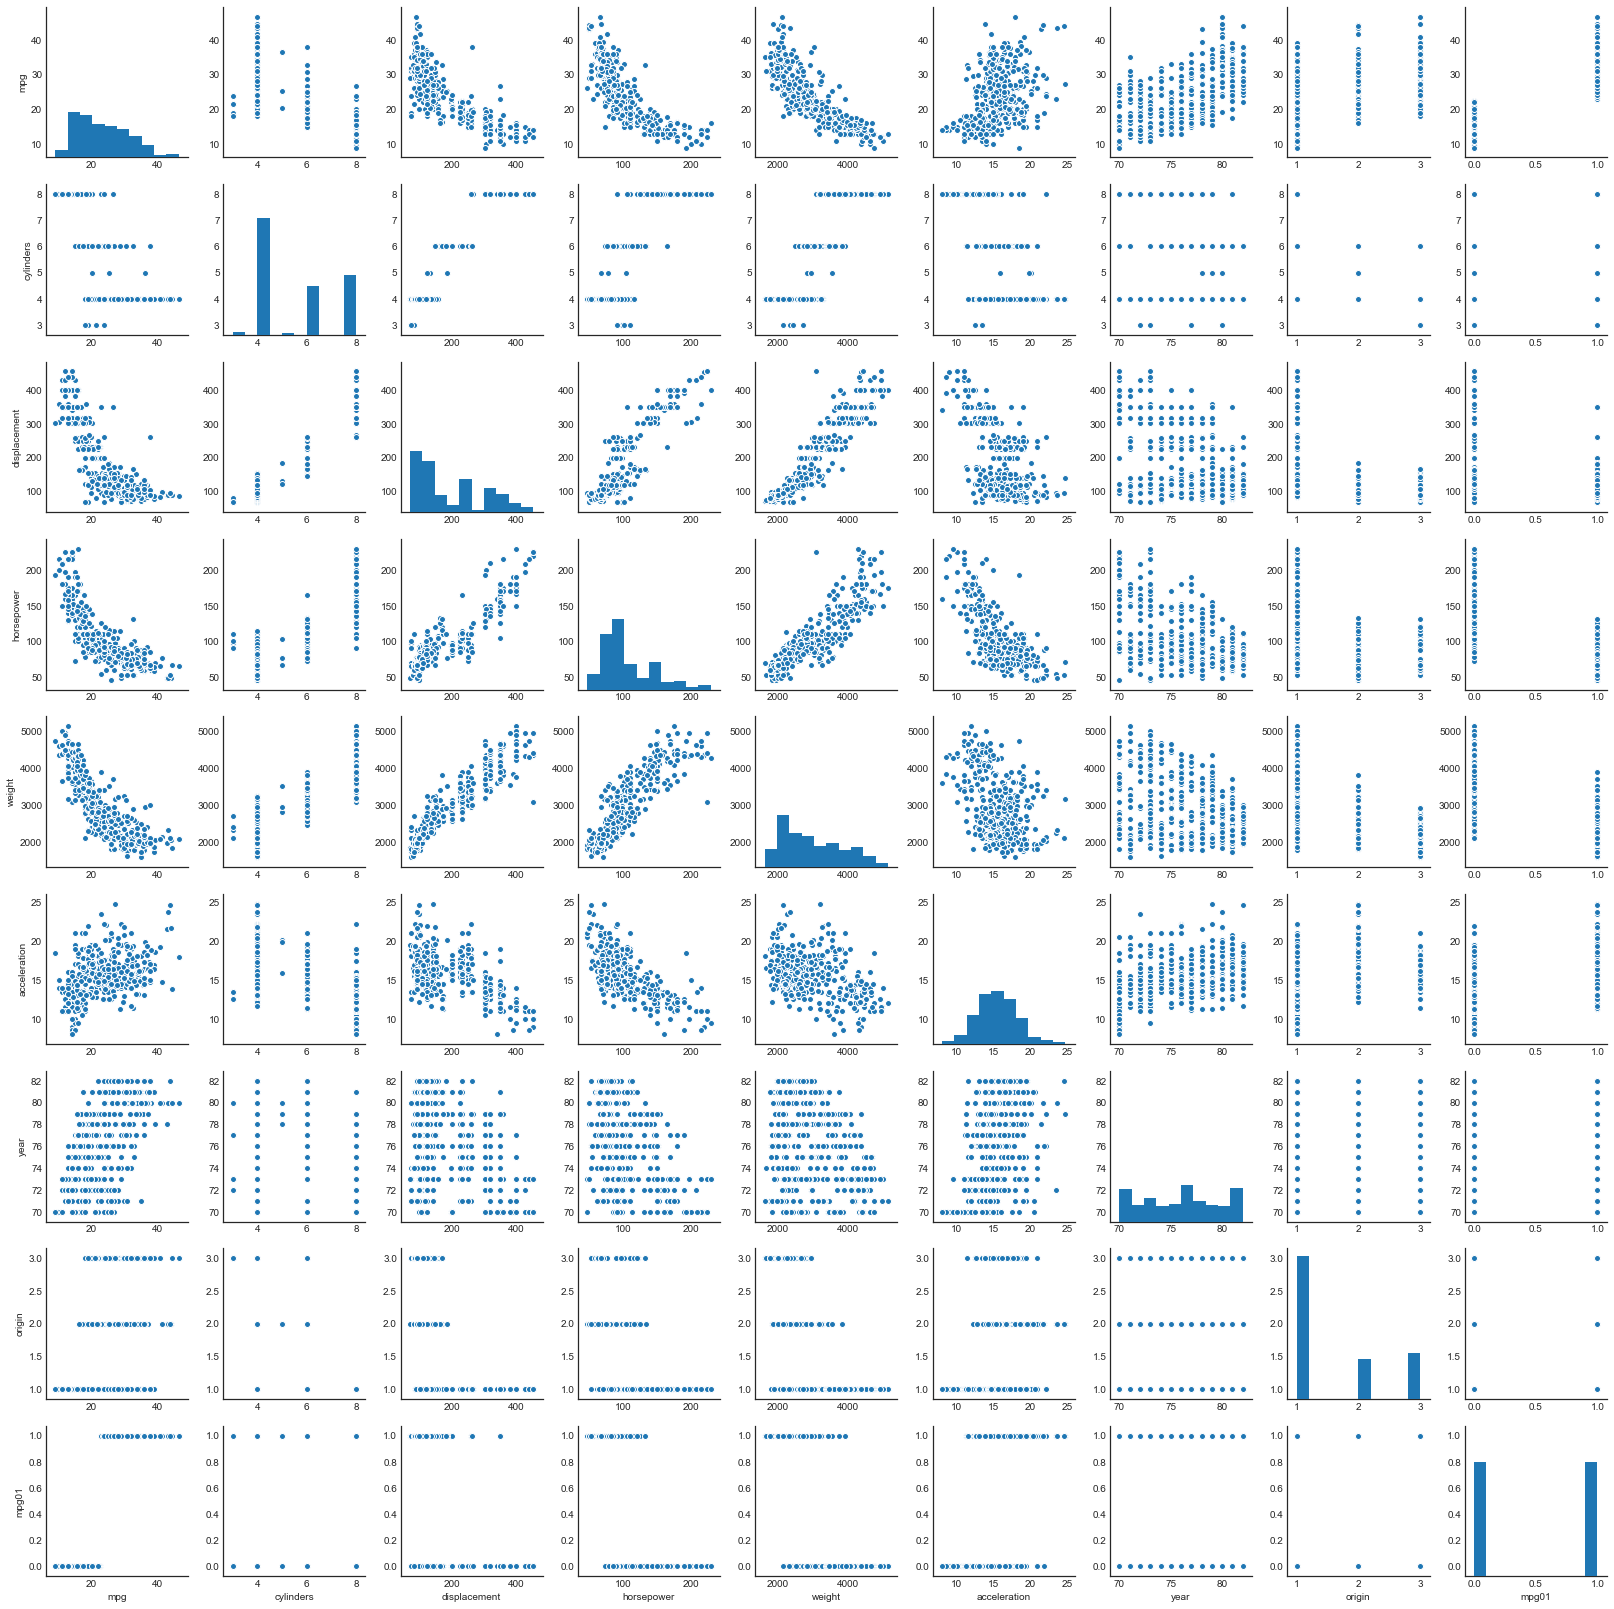

In [11]:
sns.pairplot(auto[['mpg','cylinders','displacement','horsepower','weight','acceleration','year','origin','mpg01']]);

Displacement, weight,horsepower, and acceleration look the most promising. However these variables are all fairly correlated/anti-correlated.

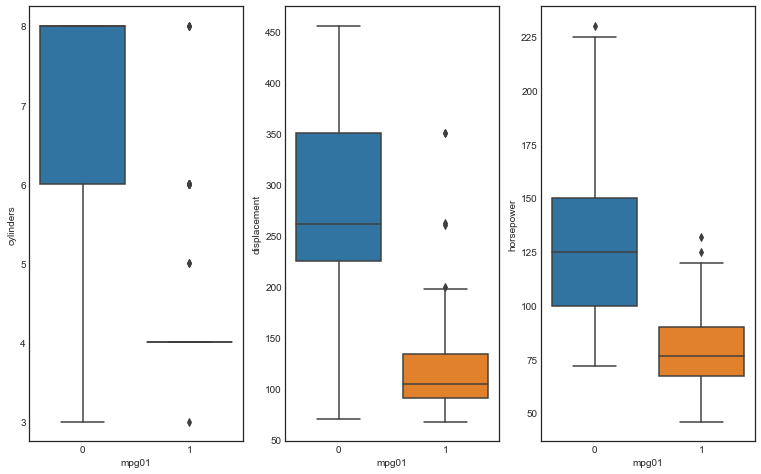

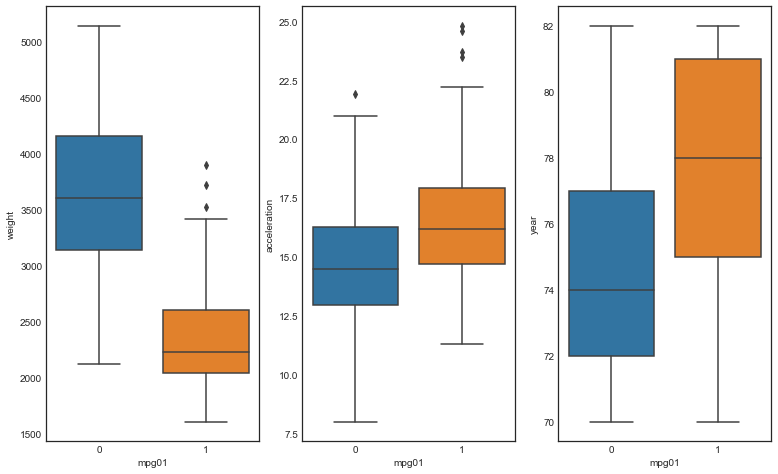

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(13,8))
fig, (ax4, ax5, ax6) = plt.subplots(1,3, figsize=(13,8))
sns.boxplot('mpg01', 'cylinders', data=auto, orient='v',ax=ax1)
sns.boxplot('mpg01', 'displacement', data=auto, orient='v',ax=ax2)
sns.boxplot('mpg01', 'horsepower', data=auto, orient='v',ax=ax3)
sns.boxplot('mpg01', 'weight', data=auto, orient='v',ax=ax4)
sns.boxplot('mpg01', 'acceleration', data=auto, orient='v',ax=ax5)
sns.boxplot('mpg01', 'year', data=auto, orient='v',ax=ax6)
plt.show()

In [13]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

/Users/arsheenkhatib/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [14]:
#Split data

X = auto[auto.columns[1:-1].difference(['name'])].values
y = auto['mpg01'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print("Training data: {} , Test data: {} ".format(len(X_train),len(X_test)))

Training data: 294 , Test data: 98 


In [15]:
#LDA

X = auto[['weight', 'displacement', 'horsepower', 'cylinders']].values
y = auto['mpg01'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train).predict(X_test)
print("Test Error: {}".format(1-accuracy_score(y_test, lda.predict(X_test))))

Test Error: 0.0714285714285714


In [16]:
#QDA

X = auto[['weight', 'displacement', 'horsepower', 'cylinders']].values
y = auto['mpg01'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
print("Test Error: {}".format(1-accuracy_score(y_test, qda.predict(X_test))))

Test Error: 0.061224489795918324


In [17]:
#logical regression:

X = auto[['weight', 'displacement', 'horsepower', 'cylinders']].values
y = auto['mpg01'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

lr = LogisticRegression()
lr.fit(X_train, y_train)
#lr.fit(X_test, y_test).score(X_test, y_test)
print("Test Error: {}".format(1-accuracy_score(y_test, lr.predict(X_test))))

Test Error: 0.10204081632653061


In [18]:
#KNN
# looks like 18-32 for K yields the best results
for k in range(1, 51):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    accuracy = accuracy_score(y_test, knn.predict(X_test))
    print('With K={} accuracy is {:.3f}'.format(k, accuracy))



With K=1 accuracy is 0.878
With K=2 accuracy is 0.857
With K=3 accuracy is 0.898
With K=4 accuracy is 0.898
With K=5 accuracy is 0.867
With K=6 accuracy is 0.888
With K=7 accuracy is 0.888
With K=8 accuracy is 0.908
With K=9 accuracy is 0.898
With K=10 accuracy is 0.898
With K=11 accuracy is 0.908
With K=12 accuracy is 0.908
With K=13 accuracy is 0.908
With K=14 accuracy is 0.908
With K=15 accuracy is 0.898
With K=16 accuracy is 0.898
With K=17 accuracy is 0.888
With K=18 accuracy is 0.918
With K=19 accuracy is 0.918
With K=20 accuracy is 0.918
With K=21 accuracy is 0.908
With K=22 accuracy is 0.908
With K=23 accuracy is 0.908
With K=24 accuracy is 0.918
With K=25 accuracy is 0.908
With K=26 accuracy is 0.918
With K=27 accuracy is 0.918
With K=28 accuracy is 0.918
With K=29 accuracy is 0.918
With K=30 accuracy is 0.918
With K=31 accuracy is 0.918
With K=32 accuracy is 0.918
With K=33 accuracy is 0.908
With K=34 accuracy is 0.908
With K=35 accuracy is 0.898
With K=36 accuracy is 0.908
W

In [19]:
#Test error for range 18 - 32
for k in range(18,32):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    accuracy = accuracy_score(y_test, knn.predict(X_test))
    print('With K={} test error is {:.3f}'.format(k, (1-accuracy)))

With K=18 test error is 0.082
With K=19 test error is 0.082
With K=20 test error is 0.082
With K=21 test error is 0.092
With K=22 test error is 0.092
With K=23 test error is 0.092
With K=24 test error is 0.082
With K=25 test error is 0.092
With K=26 test error is 0.082
With K=27 test error is 0.082
With K=28 test error is 0.082
With K=29 test error is 0.082
With K=30 test error is 0.082
With K=31 test error is 0.082


------------------------------------------------------------------------------------------------

A) Is a dataset of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. This set has been studied so much that it is often called the “Hello World” of Machine Learning: whenever people come up with a new classification algorithm, they are curious to see how it will perform on MNIST. Whenever someone learns Machine Learning, sooner or later they tackle MNIST.

In [20]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [21]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [22]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [23]:
X, y = mnist["data"], mnist["target"]

In [24]:
X.shape

(70000, 784)

In [25]:
y.shape

(70000,)

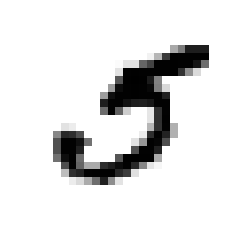

In [26]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
 interpolation="nearest")
plt.axis("off")
plt.show()

In [27]:
y[36000]

5.0

In [28]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [29]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [30]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

In [31]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

/Users/arsheenkhatib/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [32]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

In [33]:
#lda
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
lda.predict([some_digit])
accuracy_score(y_test, lda.predict(X_test))

/Users/arsheenkhatib/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/Users/arsheenkhatib/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0.873

In [34]:
#qda
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
qda.predict([some_digit])
accuracy_score(y_test, qda.predict(X_test))

/Users/arsheenkhatib/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


0.54420000000000002

In [35]:
#logistic regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.predict([some_digit])
accuracy_score(y_test, lr.predict(X_test))

0.91769999999999996

In [ ]:
#knn
for k in range(1, 51):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    accuracy = accuracy_score(y_test, knn.predict(X_test))
    print('With K={} accuracy is {:.3f}'.format(k, accuracy))

With K=1 accuracy is 0.969
With K=2 accuracy is 0.963
With K=3 accuracy is 0.971
With K=4 accuracy is 0.968
With K=5 accuracy is 0.969


In [37]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
 clone_clf = clone(sgd_clf)
 x_train_folds = X_train[train_index]
 y_train_folds = y_train_5[train_index]
 x_test_fold = X_train[test_index]
 y_test_fold = y_train_5[test_index]
 clone_clf.fit(x_train_folds, y_train_folds)
 y_pred = clone_clf.predict(x_test_fold)
 n_correct = sum(y_pred == y_test_fold)
 print(n_correct / len(y_pred)) 

/Users/arsheenkhatib/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.95695


/Users/arsheenkhatib/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.9411


/Users/arsheenkhatib/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.96


In [38]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

/Users/arsheenkhatib/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/arsheenkhatib/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


array([ 0.95695,  0.9411 ,  0.96   ])

In [39]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

/Users/arsheenkhatib/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/arsheenkhatib/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [40]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[54446,   133],
       [ 2706,  2715]])

In [41]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) 

0.9533005617977528

In [42]:
recall_score(y_train_5, y_train_pred)

0.50083010514665194

In [43]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.6566694884508405